In [5]:
import os
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.metrics import MeanSquaredError
from keras.optimizers import Adam
from keras import layers
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

## Stick Figure CNN Model + Distance Transform

# 이미지 데이터(특징값) 불러오는 함수 -> 전처리 동시에

# 이미지 데이터(특징값) 불러오는 함수 -> 전처리 동시에
def load_images(image_path):
    images = []
    for filename in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path,filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            binary_image = binary_image.astype(np.uint8)  # 이미지 형식 변환
            distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
            img = cv2.resize(distance_transform, (32, 32)) # 이미지 크기 조정
            img = img.flatten() # 이미지 일차원 배열로 변환
            images.append(img)
    return np.array(images)



# CSV(목푯값) 불러오는 함수 -> 첫 번째 열(이미지 이름) 제외
def load_csv(csv_path):
    df = pd.read_csv(csv_path, header=None)
    joint = df.iloc[:, 1:].to_numpy()
    return joint

# Load image and target data
X_train = load_images("./image_train/")
y_train = load_csv("./joint_train.csv")

for i in range(len(y_train)):
    if y_train[i][6] > y_train[i][10]:
        for j in range(6,10):
            tmp = y_train[i][j]
            y_train[i][j] = y_train[i][j+4]
            y_train[i][j+4] = tmp

    if y_train[i][14] > y_train[i][18]:
        for j in range(14,18):
            tmp = y_train[i][j]
            y_train[i][j] = y_train[i][j+4]
            y_train[i][j+4] = tmp

        

X_validation = load_images("./image_validation/")
y_validation = load_csv("./joint_validation.csv")

for i in range(len(y_validation)):
    if y_validation[i][6] > y_validation[i][10]:
        for j in range(6,10):
            tmp = y_validation[i][j]
            y_validation[i][j] = y_validation[i][j+4]
            y_validation[i][j+4] = tmp

    if y_validation[i][14] > y_validation[i][18]:
        for j in range(14,18):
            tmp = y_validation[i][j]
            y_validation[i][j] = y_validation[i][j+4]
            y_validation[i][j+4] = tmp

X_test = load_images("./image_test/")
y_test = load_csv("./joint_test.csv")

for i in range(len(y_test)):
    if y_test[i][6] > y_test[i][10]:
        for j in range(6,10):
            tmp = y_test[i][j]
            y_test[i][j] = y_test[i][j+4]
            y_test[i][j+4] = tmp

    if y_test[i][14] > y_test[i][18]:
        for j in range(14,18):
            tmp = y_test[i][j]
            y_test[i][j] = y_test[i][j+4]
            y_test[i][j+4] = tmp

X_ex = load_images("./image_ex/")
y_ex = load_csv("./joint_ex.csv")

for i in range(len(y_ex)):
    if y_ex[i][6] > y_ex[i][10]:
        for j in range(6,10):
            tmp = y_ex[i][j]
            y_ex[i][j] = y_ex[i][j+4]
            y_ex[i][j+4] = tmp

    if y_ex[i][14] > y_ex[i][18]:
        for j in range(14,18):
            tmp = y_ex[i][j]
            y_ex[i][j] = y_ex[i][j+4]
            y_ex[i][j+4] = tmp



# 데이터 전처리 (입력 이미지와 목표값 간의 매핑 필요)
x_train_preprocessed = X_train.reshape(-1, 32, 32, 1).astype('float32') / 255.0
x_validation_preprocessed = X_validation.reshape(-1, 32, 32, 1).astype('float32') / 255.0
x_test_preprocessed = X_test.reshape(-1, 32, 32, 1).astype('float32') / 255.0
x_ex_preprocessed = X_ex.reshape(-1, 32, 32, 1).astype('float32') / 255.0

# 모델 구축
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(22)) 

model.device('cuda')


# 모델 컴파일
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# 모델 학습
history = model.fit(x_train_preprocessed, y_train, epochs=1000, batch_size=32, validation_data=(x_validation_preprocessed, y_validation))
X_train.shape


AttributeError: 'Sequential' object has no attribute 'device'

In [ ]:
X_ex = load_images("./image_ex/")
y_ex = load_csv("./joint_ex.csv")

y_train.shape
X_validation.shape
y_validation.shape
X_test.shape
y_test.shape
X_ex.shape
y_ex.shape

# 모델 평가
test_loss, test_mae = model.evaluate(x_test_preprocessed, y_test)
print('Test MAE:', test_mae)

# 모델 예측
y_pred = model.predict(x_test_preprocessed)

# R-Squared 계산
total_sum_squares = np.sum((y_test - np.mean(y_test,axis=0)) ** 2)
residual_sum_squares = np.sum((y_test - y_pred) ** 2)
r_squared = 1 - (residual_sum_squares / total_sum_squares)

print('R-Squared:', r_squared)


from sklearn.metrics import r2_score
r_squared_s = r2_score(y_test, y_pred)
print('R-Squared_s:', r_squared_s)

# 이미지 예측
predictions = model.predict(x_ex_preprocessed)

# 예측 결과 출력
#for i in range(len(predictions)):
#    print("Image", i+1, "Predicted Coordinates:", predictions[i])

print("x_ex 예측 좌표값:", predictions)  
print("실제 x_ex 좌표값:", y_ex)
print("오차:", predictions - y_ex)

# 오차 평균 구하기
average = np.mean(abs(predictions - y_ex))
print("오차 평균의 절대값:", abs(average))

125/125 [==============================] - 2s 14ms/step - loss: 102.9211 - mae: 5.6178
Test MAE: 5.617763042449951
125/125 [==============================] - 2s 14ms/step
R-Squared: 0.783800928456174
R-Squared_s: 0.6900929511557856
1/1 [==============================] - 0s 445ms/step
x_ex 예측 좌표값: [[175.81631  179.28731  165.50078  120.247795 164.43295   93.30844
  134.55507  114.3256   114.802986 126.855804 199.40825  126.75456
  203.26265  153.52756  120.0384   203.79195   66.45231  244.88974
  220.85469  221.86174  269.94522  266.8104  ]]
실제 x_ex 좌표값: [[175 105 183 179 192 200 222 217 225 274 126 209 109 265 224  54 242  46
  107  80  78  69]]
오차: [[   0.8163147    74.28730774  -17.4992218   -58.7522049   -27.56704712
  -106.69155884  -87.44493103 -102.67440033 -110.19701385 -147.14419556
    73.4082489   -82.24543762   94.26264954 -111.47244263 -103.96160126
   149.79194641 -175.54769135  198.88973999  113.85469055  141.86174011
   191.94522095  197.81039429]]
오차 평균의 절대값: 107.642090

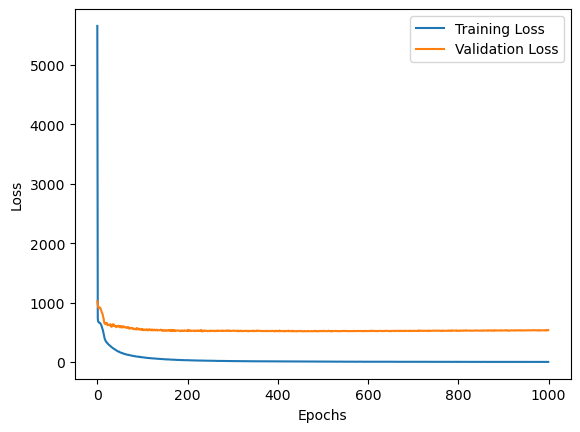

In [ ]:
X_ex = load_images("./image_ex/")
y_ex = load_csv("./joint_ex.csv")

# 손실값 기록
loss = history.history['loss']
val_loss = history.history['val_loss']

# 지표 기록
mae = history.history['mae']
val_mae = history.history['val_mae']

# 시각화 

import matplotlib.pyplot as plt



# 손실값 그래프
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



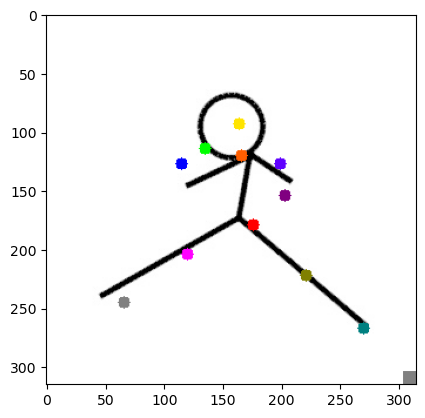

In [ ]:
imageFile = './image_ex/sf_t.png'
X_ex_image = cv2.imread(imageFile)

# 각 관절 위치 값 저장
data=predictions[0]

c1_x = int(round(data[0]))           
c1_y = int(round(data[1]))            
c2_x = int(round(data[2]))             
c2_y = int(round(data[3]))             
c3_x = int(round(data[4]))             
c3_y = int(round(data[5]))             
le_x = int(round(data[6]))             
le_y = int(round(data[7]))            
lh_x = int(round(data[8]))             
lh_y = int(round(data[9]))             
re_x = int(round(data[10]))             
re_y = int(round(data[11]))             
rh_x = int(round(data[12]))             
rh_y = int(round(data[13]))             
lk_x = int(round(data[14]))             
lk_y = int(round(data[15]))              
lf_x = int(round(data[16]))             
lf_y = int(round(data[17]))             
rk_x = int(round(data[18]))             
rk_y = int(round(data[19]))             
rf_x = int(round(data[20]))             
rf_y = int(round(data[21]))  



cv2.circle(X_ex_image,(c1_x,c1_y), radius=5, color=(0,0,255), thickness=-1)  #빨
cv2.circle(X_ex_image,(c2_x,c2_y), radius=5, color=(0,94,255), thickness=-1)  #주
cv2.circle(X_ex_image,(c3_x,c3_y), radius=5, color=(0,228,255), thickness=-1) #노
cv2.circle(X_ex_image,(le_x,le_y), radius=5, color=(0,255,0), thickness=-1)  #초
cv2.circle(X_ex_image,(lh_x,lh_y), radius=5, color=(255,0,0), thickness=-1)  #파
cv2.circle(X_ex_image,(re_x,re_y), radius=5, color=(255,0,95), thickness=-1)
cv2.circle(X_ex_image,(rh_x,rh_y), radius=5, color=(128,0,128), thickness=-1)
cv2.circle(X_ex_image,(lk_x,lk_y), radius=5, color=(255,0,255), thickness=-1)
cv2.circle(X_ex_image,(lf_x,lf_y), radius=5, color=(128,128,128), thickness=-1)
cv2.circle(X_ex_image,(rk_x,rk_y), radius=5, color=(0,128,128), thickness=-1)
cv2.circle(X_ex_image,(rf_x,rf_y), radius=5, color=(128,128,0), thickness=-1)


img = cv2.cvtColor(X_ex_image, cv2.COLOR_BGR2RGB)

#이미지, 점 출력
plt.imshow(img)
plt.show()


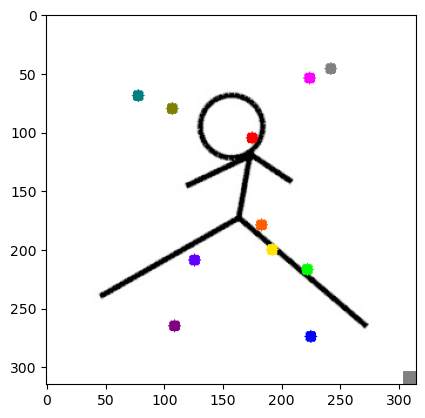

array([[175, 105, 183, 179, 192, 200, 222, 217, 225, 274, 126, 209, 109,
        265, 224,  54, 242,  46, 107,  80,  78,  69]], dtype=int64)

In [ ]:
imageFile = './image_ex/sf_t.png'
X_ex_image = cv2.imread(imageFile)

# 각 관절 위치 값 저장
data=y_ex[0]

c1_x = int(round(data[0]))           
c1_y = int(round(data[1]))            
c2_x = int(round(data[2]))             
c2_y = int(round(data[3]))             
c3_x = int(round(data[4]))             
c3_y = int(round(data[5]))             
le_x = int(round(data[6]))             
le_y = int(round(data[7]))            
lh_x = int(round(data[8]))             
lh_y = int(round(data[9]))             
re_x = int(round(data[10]))             
re_y = int(round(data[11]))             
rh_x = int(round(data[12]))             
rh_y = int(round(data[13]))             
lk_x = int(round(data[14]))             
lk_y = int(round(data[15]))              
lf_x = int(round(data[16]))             
lf_y = int(round(data[17]))             
rk_x = int(round(data[18]))             
rk_y = int(round(data[19]))             
rf_x = int(round(data[20]))             
rf_y = int(round(data[21]))  



cv2.circle(X_ex_image,(c1_x,c1_y), radius=5, color=(0,0,255), thickness=-1)  #빨
cv2.circle(X_ex_image,(c2_x,c2_y), radius=5, color=(0,94,255), thickness=-1)  #주
cv2.circle(X_ex_image,(c3_x,c3_y), radius=5, color=(0,228,255), thickness=-1) #노
cv2.circle(X_ex_image,(le_x,le_y), radius=5, color=(0,255,0), thickness=-1)  #초
cv2.circle(X_ex_image,(lh_x,lh_y), radius=5, color=(255,0,0), thickness=-1)  #파
cv2.circle(X_ex_image,(re_x,re_y), radius=5, color=(255,0,95), thickness=-1)
cv2.circle(X_ex_image,(rh_x,rh_y), radius=5, color=(128,0,128), thickness=-1)
cv2.circle(X_ex_image,(lk_x,lk_y), radius=5, color=(255,0,255), thickness=-1)
cv2.circle(X_ex_image,(lf_x,lf_y), radius=5, color=(128,128,128), thickness=-1)
cv2.circle(X_ex_image,(rk_x,rk_y), radius=5, color=(0,128,128), thickness=-1)
cv2.circle(X_ex_image,(rf_x,rf_y), radius=5, color=(128,128,0), thickness=-1)


img = cv2.cvtColor(X_ex_image, cv2.COLOR_BGR2RGB)

#이미지, 점 출력
plt.imshow(img)
plt.show()
y_ex
